# Abstract neural nets

In this particular notebook we will look at the example of training the neural networks, that consist of dense (fully connected) and convolutional layers. The models, what we will be using can be changed and modified according to the structure, provided in the examples (therefore, the classes, implementing this functionality are considered abstract constructors).

## Table of contents

You can navigate over the document using these hyperlinks:
* [Data preparation](#Data-preparation)
* [Dense net exaple](#Dense-net-example)
* [Convolutional net example](#Convolutional-net-example)
* [Conclusion](#Conclusion)

Now let's get started.

***

## Imports

We first need to resolve the relative import issue, which occurs due to package scope, executing the following cell.

In [1]:
import sys

sys.path.append("../")

Below we have the imports of Matplotlib's Pyplot, `randint()` function from NumPy and `read_csv()` from Pandas. We will need these to visualize and load the data. There're also imports of modules from the Scratches library, examples of usage of which would be provided futher in the document.

In [2]:
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
from pandas import read_csv

from scratches.preprocessing import (
    DataSplitter,
    normalize_data,
    reshape_channel_images,
    revert_matrix,
    tokenize_probabilities,
    transform_binary,
)
from scratches.models.evaluation import (
    compute_accuracy, 
    compute_confusion_matrix,
)
from scratches.models.abstract import (
    ConvolutionalLayer,
    DenseLayer,
    NeuralNetwork,
    Trainer,
    TanHFunctionOperator,
    SGDMomentumOptimizer,
    SigmoidFunctionOperator,
    SoftmaxCEEvaluator,
)

***

## Data preparation

Every machine learning workflow starts with the data preparation process. And this notebook is no exception.

### Loading the data

Let's load the MNIST dataset, which contains 70,000 images (28 by 28 pixels each) of labeled digits from 0 to 9. We will use it for both dense and convolutional neural networks. (We need to unzip it first.)

In [3]:
with ZipFile("datasets/mnist.zip", "r") as zip_ref:
    zip_ref.extractall("datasets")

data = read_csv("datasets/mnist.csv")

Now, let's look at the random digit from our dataset. 

We wrap the image demonstration code into a function, since we'll need to repeat it later on.

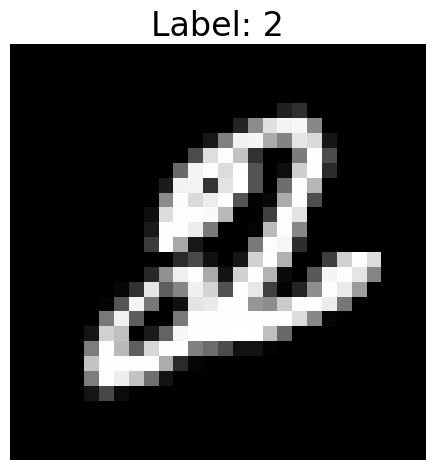

In [4]:
def show_random_image(images: ndarray, title: str) -> None:
    index = np.random.randint(0, len(images))
    image, label = (images[index, 1:].reshape((28, 28)), images[index, 0])
    
    plt.axis("off")
    plt.title(f"{title}: {int(label)}", fontsize=24)
    plt.tight_layout()
    plt.imshow(image, cmap="grey")


data_numpy = data.to_numpy()

show_random_image(data_numpy, "Label")

### Preprocessing the data

In the following cells we split the dataset in the training, validation and testing sets, using the `DataSplitter` class. Then we need to perform one-hot encoding of the labels with the `transform_binary()` function for training and validating our model.

In [5]:
splitter = DataSplitter(permute=True, random_seed=20240604)
x_train, x_valid, x_test, y_train, y_valid, y_test = splitter.split_data(
    data.drop(columns=["label"]).to_numpy(),
    data["label"].to_numpy().reshape((-1, 1)),
    test_size=0.15, 
    valid_size=0.20,
)
y_train, y_valid = transform_binary(y_train), transform_binary(y_valid)

Also normalizing our data using `normalize_data()` function speeds up the training process and increases overall accuracy of the model.

In [6]:
x_train, x_valid, x_test = (
    normalize_data(to_normalize=x_train, std_from=x_train),
    normalize_data(to_normalize=x_valid, std_from=x_train),
    normalize_data(to_normalize=x_test, std_from=x_train),
)

***

## Dense net example

Now we are getting to the first interseting part of the notebook — defining the structure and training of our model.

### Defining a model

You can observe the list of steps, needed to construct a model below.

 * Initialize the dictionary of layers in order they must consume the data using the `DenseLayer` class;
 * Initialize the optimizer (in this case it is `SGDMomentumOptimizer`), which would tweak parameters of the model;
 * Initialize the net with the `NeuralNetwork` class, specifying the layers and the loss function (we have `SoftmaxCEEvaluator` here);
 * Initialize the trainer of your model using the `Trainer` class, providing the model and the optimizer as arguments;
 * Fit the model to the data, perfoming the `Trainer.fit()` method usage.

The order of initializations can be changed. 

List of all avalible parameters and their detailed description can be found in the source code as docstrings.

In [7]:
dense_layers = {
    "dense0": DenseLayer(
        n_neurons=46,
        activation_function=TanHFunctionOperator(),
        weight_initialization="Glorot",
        dropout_rate=0.8,
    ),
    "output": DenseLayer(
        n_neurons=10,
        activation_function=SigmoidFunctionOperator(),
        weight_initialization="Glorot",
    ),
}
optimizer = SGDMomentumOptimizer(
    learning_rate=0.3, 
    final_learning_rate=0.05,
    momentum=0.8,
    decay_type="exponential"
)
dense_net = NeuralNetwork(
    layers=dense_layers,
    loss_function=SoftmaxCEEvaluator(),
    random_seed=20240604,
)
trainer = Trainer(network=dense_net, optimizer=optimizer)

trainer.fit(
    x_train, 
    x_valid, 
    y_train, 
    y_valid, 
    epochs=120,
    evaluate_every_epochs=10,
    batch_size=60,
    stop_early=False,
    random_seed=20240604,
)

Trainer: Validation loss after 10 epochs is 7.0871026313898575.
Trainer: Validation loss after 20 epochs is 6.988128959435087.
Trainer: Validation loss after 30 epochs is 6.962139135529679.
Trainer: Validation loss after 40 epochs is 6.9515218100281535.
Trainer: Validation loss after 50 epochs is 6.945783488726979.
Trainer: Validation loss after 60 epochs is 6.942444271455598.
Trainer: Validation loss after 70 epochs is 6.937437141017769.
Trainer: Validation loss after 80 epochs is 6.931052984193094.
Trainer: Validation loss after 90 epochs is 6.927619424084962.
Trainer: Validation loss after 100 epochs is 6.920240619151333.
Trainer: Validation loss after 110 epochs is 6.929113289375536.
Trainer: Validation loss after 120 epochs is 6.913886741294324.
Trainer: Training complete! It took 89.7898638000479 seconds.


### Evaluating the model

We now need to see how good our model actually is. We can observe exact results of predicting the test labels on the confusion matrix in the output of the cell below. But the convertion of the one-hor encoded vectors to the actual digits must be done first, using the `tokenize_prababilities()` (translates the probabilities to the binary matrix) and `revert_matrix()` (turns the binary matrix into vector of actual digits). 

Also the code for confusion matrix visualization should be wrapped into a function since we'll need to use it one more time.

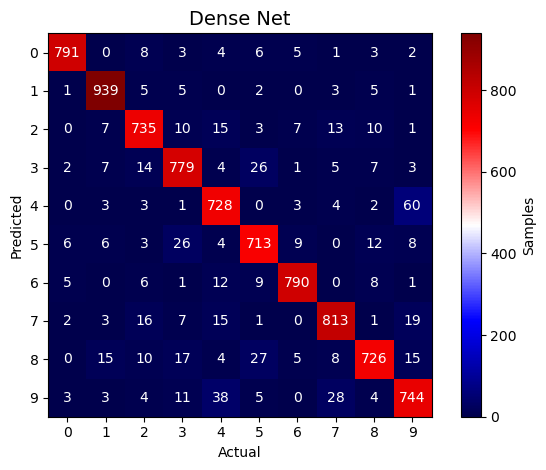

In [8]:
def visualize_confusion_matrix(
    title: str, actual: ndarray, predicted: ndarray
) -> None:
    confusion_matrix, _ = compute_confusion_matrix(actual, predicted)
    figure, axis = plt.subplots()
    ticks = list(range(0, len(confusion_matrix)))
    
    axis.set_yticks(ticks)
    axis.set_xticks(ticks)
    axis.set_xlabel("Actual")
    axis.set_ylabel("Predicted")
    for i, _ in enumerate(confusion_matrix):
        for j, _ in enumerate(confusion_matrix):
            axis.text(
                j, i, int(confusion_matrix[i, j]),
                verticalalignment="center", 
                horizontalalignment="center", 
                color="white"
            )
    axis.set_title(title, fontsize=14)
    to_show = plt.imshow(confusion_matrix, cmap="seismic")
    figure.colorbar(to_show, label="Samples")
    
    plt.tight_layout()
    plt.show()


y_predicted = dense_net.feed_forward(x_test)
y_predicted = revert_matrix(tokenize_probabilities(y_predicted))

visualize_confusion_matrix("Dense Net", y_test, y_predicted)

For numerical clarity You can make use of the `compute_accuray()` function, which returns the decimal score of the model. Here we have pretty impressive results (92.357 in the percentage equivalent).

In [9]:
compute_accuracy(y_test, y_predicted)

0.9235714285714286

For the detailed review You can now pick random image and the predicted label to display, executing the following cell.

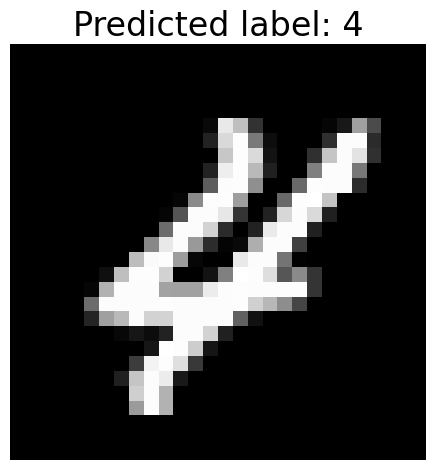

In [10]:
images_and_predictions = np.concatenate([y_predicted, x_test], axis=1)

show_random_image(images_and_predictions, "Predicted label")

***

## Convolutional net example

In the following cells we demonstrate the building process of the convolutional neural network. It not exactly what we've seen earlier. Let's have a look at these differences.

### Additional data reshaping

Before initialization we have to reshape our existing data, because our model won't longer treat the data as just a structured set of numbers (and try to figure out the connections between data point). It's now looks at the data as an image and tries to detect the actual patterns, and what they can tell about the content on the image itself.

In the cell below we convert our column vectors of pixels to channel images using `reshape_channel_images()` function (assuming all the previous data preparation steps are already done).

In [11]:
x_train_conv, x_valid_conv, x_test_conv = (
    reshape_channel_images(x_train, 1, image_height=28, image_width=28),
    reshape_channel_images(x_valid, 1, image_height=28, image_width=28),
    reshape_channel_images(x_test, 1, image_height=28, image_width=28),
)

### Defining a model

Now, having the perfectly fitting data for our network, we can train it. But have a look at the layers first. We now use the `ConvolutionalLayer` class to initialize the layer, that performs convolutions with our images to detect patterns. Overall procedure doesn't change alot, except this time we specify the number of output channels and the size of parameter kernel instead of number of neurons.

In [12]:
conv_layers = {
    "conv0": ConvolutionalLayer(
        output_channels=8,
        parameter_size=7,
        activation_function=TanHFunctionOperator(),
        weight_initialization="Glorot",
        dropout_rate=0.8,
        apply_flatten=True,
    ),
    "output": DenseLayer(
        n_neurons=10,
        activation_function=SigmoidFunctionOperator(),
        weight_initialization="Glorot",
    ),
}
optimizer = SGDMomentumOptimizer(
    learning_rate=0.1, 
    final_learning_rate=0.05,
    momentum=0.9,
    decay_type="exponential"
)
conv_net = NeuralNetwork(
    layers=conv_layers,
    loss_function=SoftmaxCEEvaluator(),
    random_seed=20240604,
)
trainer = Trainer(network=conv_net, optimizer=optimizer)

trainer.fit(
    x_train_conv, 
    x_valid_conv, 
    y_train, 
    y_valid, 
    epochs=3,
    evaluate_every_epochs=1,
    evaluate_every_batches=100,
    batch_size=60,
    random_seed=20240604,
)

Trainer: Loss after 100 batches is 4.232614890382931.
Trainer: Loss after 200 batches is 3.7506101245268058.
Trainer: Loss after 300 batches is 3.6804866479625105.
Trainer: Loss after 400 batches is 3.7024293677420093.
Trainer: Loss after 500 batches is 3.645544928091876.
Trainer: Loss after 600 batches is 3.6175677695548294.
Trainer: Loss after 700 batches is 3.615307699993777.
Trainer: Loss after 800 batches is 3.600226858425854.
Trainer: Loss after 900 batches is 3.6527264840139906.
Trainer: Validation loss after 1 epochs is 7.04071531739417.
Trainer: Loss after 100 batches is 3.592948168357808.
Trainer: Loss after 200 batches is 3.637938242431343.
Trainer: Loss after 300 batches is 3.579050040874114.
Trainer: Loss after 400 batches is 3.59887505242487.
Trainer: Loss after 500 batches is 3.6074874921345224.
Trainer: Loss after 600 batches is 3.66951604801226.
Trainer: Loss after 700 batches is 3.5810061770825663.
Trainer: Loss after 800 batches is 3.5792735457019593.
Trainer: Loss a

### Evaluating the model

The model has been trained successfully. We can now have a look at the results on the confusion matrix in the output of the cell below.

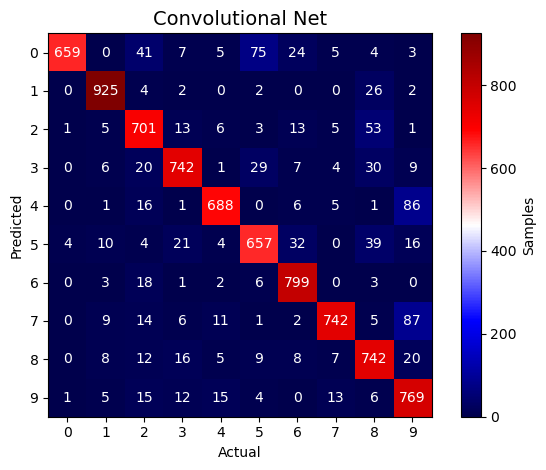

In [13]:
y_predicted = conv_net.feed_forward(x_test_conv)
y_predicted = revert_matrix(tokenize_probabilities(y_predicted))

visualize_confusion_matrix("Convolutional Net", y_test, y_predicted)

And here is the part of the data, that has been predicted correctly.

In [14]:
compute_accuracy(y_test, y_predicted)

0.8838095238095238

Although it took a while (skill issue), it learns faster than dense net in terms of epochs and iterations. And the accuracy is very impressive for just 3 epochs. Notice how dense net needed 40 epochs to get the same loss as the convolutional one.

As with the dense net, execute the following cell to pick a random image with the predicted label.

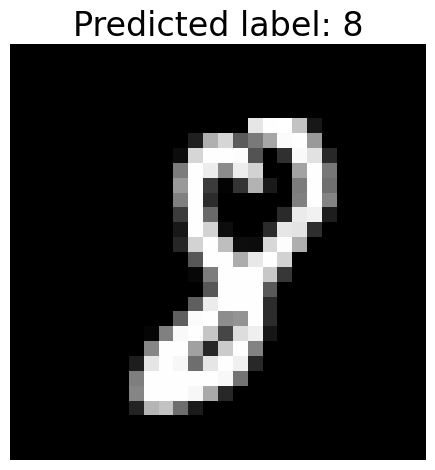

In [15]:
images_and_predictions = np.concatenate([y_predicted, x_test], axis=1)

show_random_image(images_and_predictions, "Predicted label")

***

## Conclusion

In this document we have covered the basics and reviewed some examples of usage the abstract models constructors to build simple neural nets. You also possibly already mentioned, that the workflow is very similar to the PyTorch usage experince.

What can we say to conclude? Predictions are pretty accurate. Although the training process takes some time, You are still able to obtain good results.

Now that You have seen how to use neural networks constructors (only for educational purposes, of course), You can play with them, appealing to the source code for the documentation.